In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv('data.csv', sep=';')
df=df.dropna(axis=0)

In [20]:
liste_variables_df = list(df.columns)
for variable in liste_variables_df:
    if df[variable].dtype == 'object':
        df[variable] = df[variable].str.replace(',', '.').astype(float)

print(df.head())

   abuse  status  unemrate  age  educ  married  famsize  white  northeast  \
0      1       1       4.0   50     4        1        1      1          0   
1      0       3       4.0   37    12        1        5      1          0   
2      0       3       4.0   53     9        1        3      1          0   
3      0       3       3.3   59    11        1        1      1          1   
4      0       3       3.3   43    10        1        1      1          1   

   midwest  south  cigtax  employ  
0        1      0    38.0       0  
1        1      0    38.0       1  
2        1      0    38.0       1  
3        0      0    26.0       1  
4        0      0    26.0       1  


In [21]:
y = df['abuse']
X = df.drop(['abuse'],axis=1)

liste_variables_df.remove('abuse')

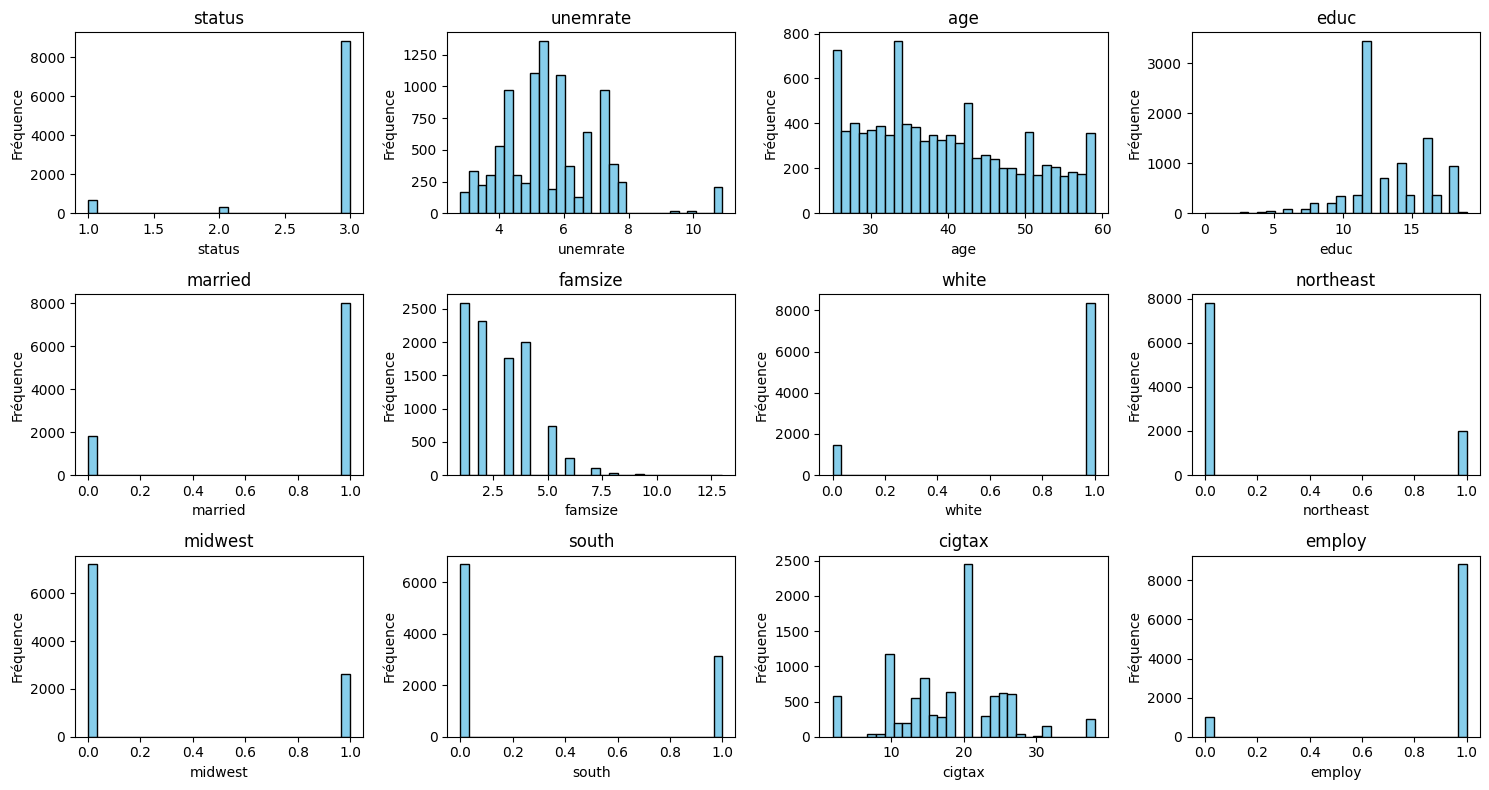

<Axes: xlabel='abuse'>

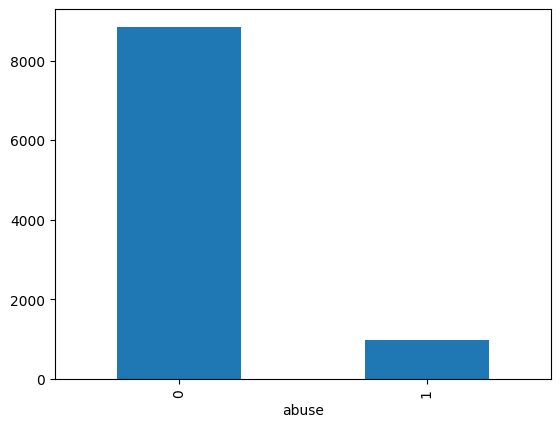

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(liste_variables_df):
    axes[i].hist(X[var], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()


y.value_counts().plot.bar()

In [23]:
print(y.value_counts())

abuse
0    8848
1     974
Name: count, dtype: int64


Underrepresentation of class 1. We will first try to solve the problem with an SGDClassifier given the amount of data, but we will likely switch to a random forest or XGBoost if we have difficulty predicting the underrepresented class.

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
CV=StratifiedKFold(5)


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



cvs = cross_val_score(
    SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    X_train_scaled, y_train, cv= CV
)

print(cvs)

y_pred_cv = cross_val_predict(
    SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    X_train_scaled, y_train, cv=CV
)

print("report cv:\n", classification_report(y_train, y_pred_cv))

print("cv accuracy: {:.3f} ± {:.3f}".format(cvs.mean(), cvs.std()))




[0.89949109 0.89949109 0.89688097 0.8478676  0.89942712]
report cv:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7067
           1       0.04      0.01      0.01       790

    accuracy                           0.89      7857
   macro avg       0.47      0.50      0.48      7857
weighted avg       0.81      0.89      0.85      7857

cv accuracy: 0.889 ± 0.020


Indeed, it is difficult to accurately predict class 1.

We are trying to see what we get with hyperparameters.

In [83]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

In [59]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss', max_iter=10000, random_state=0))
])


param_grid = {
    'sgd__alpha': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2], 
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],
    'sgd__loss': ['log_loss', 'hinge'],
    'sgd__class_weight': ['balanced', None] #class_weight = None pour accorder plus de poids à la classe 1
}

In [60]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)

Meilleurs hyperparamètres : {'sgd__alpha': 0.0001, 'sgd__class_weight': None, 'sgd__loss': 'log_loss', 'sgd__penalty': 'l2'}


In [61]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nAccuracy sur le jeu de test :", accuracy_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))


Accuracy sur le jeu de test : 0.9063613231552163

Classification report :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1781
           1       0.00      0.00      0.00       184

    accuracy                           0.91      1965
   macro avg       0.45      0.50      0.48      1965
weighted avg       0.82      0.91      0.86      1965



/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

We still can't accurately predict class 1. Before moving on to RandomForest, we'll try with KNN.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

cv=StratifiedKFold(5) 

param_grid={'n_neighbors':np.arange(1,20),
            'metric' : ['minkowski'],
            'p':np.arange(1,5)}
#different parameters

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv) #use grid search to find the best ones

grid.fit(X_train,y_train)


print(f'the best score obtained is : {grid.best_score_}, the best parameters are : {grid.best_params_}')
    
mod=grid.best_estimator_
print(mod.score(X_test,y_test))

print(confusion_matrix(y_test,mod.predict(X_test)))

the best score obtained is : 0.8995799340139261, the best parameters are : {'metric': 'minkowski', 'n_neighbors': np.int64(13), 'p': np.int64(1)}
0.9063613231552163
[[1781    0]
 [ 184    0]]


Same problem as before: 184 alcohol abusers were incorrectly predicted and not detected.

### TEST WITH RANDOMFOREST

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


clf = RandomForestClassifier(n_estimators=100, random_state=42)


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)


In [66]:
print(f'accuracy : {accuracy}')
print("\nClassification report :\n", classification_report(y_test, y_pred))


importances = clf.feature_importances_
print("\nImportance des variables :")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")

accuracy : 0.8727735368956743

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      1769
           1       0.09      0.03      0.05       196

    accuracy                           0.87      1965
   macro avg       0.50      0.50      0.49      1965
weighted avg       0.82      0.87      0.84      1965


Importance des variables :
status: 0.014320734038458996
unemrate: 0.10682218195434509
age: 0.39444724665815056
educ: 0.18666418235532337
married: 0.02081316789210061
famsize: 0.10144530255576212
white: 0.025374454896649537
northeast: 0.009143571105797357
midwest: 0.01297606459824211
south: 0.01506115348886941
cigtax: 0.10353080250268179
employ: 0.009401137953619236


In [67]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)

In [69]:
print(f"accuracy : {accuracy}")
print("\nClassification report :\n", classification_report(y_test, y_pred))


importances = clf.feature_importances_
print("\nImportance des variables :")
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")

accuracy : 0.8646310432569975

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1769
           1       0.06      0.03      0.04       196

    accuracy                           0.86      1965
   macro avg       0.48      0.49      0.48      1965
weighted avg       0.82      0.86      0.84      1965


Importance des variables :
status: 0.0159762313682296
unemrate: 0.12000635850823775
age: 0.35012351347842763
educ: 0.18093481538076242
married: 0.02062526495843969
famsize: 0.11584604424665838
white: 0.028092053737378123
northeast: 0.01099172954349096
midwest: 0.015325741197049526
south: 0.016759319391698863
cigtax: 0.11542260427394868
employ: 0.009896323915678537


We can see here that it is still difficult to predict class 1, despite using random forest.

We will try to use oversampling of the minority class.

In [70]:
from imblearn.over_sampling import SMOTE

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [72]:
print("Répartition des classes avant SMOTE :")
print(y_train.value_counts())

print("\nRépartition des classes après SMOTE :")
print(pd.Series(y_train_res).value_counts())

Répartition des classes avant SMOTE :
abuse
0    7067
1     790
Name: count, dtype: int64

Répartition des classes après SMOTE :
abuse
0    7067
1    7067
Name: count, dtype: int64


In [74]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)


In [75]:
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

In [76]:
print("\naccuracy :", accuracy_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))


accuracy : 0.8269720101781171

Classification report :
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1781
           1       0.11      0.12      0.11       184

    accuracy                           0.83      1965
   macro avg       0.51      0.51      0.51      1965
weighted avg       0.83      0.83      0.83      1965



In [89]:
param_grid = {
    'n_estimators': [10, 20, 45],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],   
    'bootstrap': [True, False]       
}


In [90]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_lea

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 45]},
             scoring='accuracy', verbose=2)

In [91]:
print("Meilleurs hyperparamètres :", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


print("\accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))

Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 45}
ccuracy : 0.8305343511450382

Classification report :
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      1781
           1       0.12      0.12      0.12       184

    accuracy                           0.83      1965
   macro avg       0.51      0.51      0.51      1965
weighted avg       0.83      0.83      0.83      1965



In [92]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 45]},
             scoring='accuracy', verbose=2)

In [93]:
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire sur le jeu de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Afficher les résultats
print("\nAccuracy sur le jeu de test :", accuracy_score(y_test, y_pred))
print("\nClassification report :\n", classification_report(y_test, y_pred))

Meilleurs hyperparamètres : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 45}

Accuracy sur le jeu de test : 0.9063613231552163

Classification report :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1781
           1       0.00      0.00      0.00       184

    accuracy                           0.91      1965
   macro avg       0.45      0.50      0.48      1965
weighted avg       0.82      0.91      0.86      1965



/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/killianguillaume/Desktop/python/test_ml/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

We can see here that the use of oversampling has worked; even though we lose a little precision, we are able to better predict class 1.

### TEST WITH XGBoost

In [94]:
import xgboost as xgb

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,           # Nombre d'arbres
    max_depth=6,                # Profondeur maximale des arbres
    learning_rate=0.1,          # Taux d'apprentissage
    objective='binary:logistic',  # Objectif pour classification binaire
    random_state=42             # Pour la reproductibilité
)


In [96]:
model.fit(X_train_res, y_train_res)
y_pred = model.predict(X_test_scaled)


In [97]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le jeu de test : {accuracy}")

# Afficher le classification report
print("\nClassification report :\n", classification_report(y_test, y_pred))

Accuracy sur le jeu de test : 0.5582697201017812

Classification report :
               precision    recall  f1-score   support

           0       0.92      0.56      0.70      1781
           1       0.11      0.52      0.18       184

    accuracy                           0.56      1965
   macro avg       0.51      0.54      0.44      1965
weighted avg       0.84      0.56      0.65      1965



Exception ignored in: <function ResourceTracker.__del__ at 0x10e621ee0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10f919ee0>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

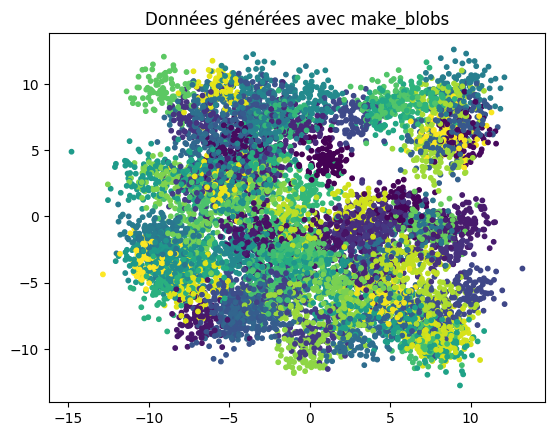

In [41]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


A, b = make_blobs(n_samples=10000, n_features=10, centers=100, random_state=0)


plt.scatter(A[:, 0], A[:, 1], c=b, cmap='viridis', s=10)
plt.title("Données générées avec make_blobs")
plt.show()
